<a href="https://colab.research.google.com/github/KilyongLee/Kilyong99/blob/main/RNN_CNN/01_RNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [SK Hynix]
## Predictive Data Analytics 10_RNN_AE
## Chapter 1. RNN : Recurrent Neural Network
## #1 RNN 분류  

* RNN은 CNN과 같이 현업에서 가장 많이 사용하는 모델 중 하나입니다.
* 금일 실습에서는 다양한 데이터를 활용한 3가지 RNN 모델을 실습하겠습니다.

#### 구현할 RNN 모델 
* 1) 이미지 데이터를 활용한 RNN 모델 (분류)
* 2) 시계열 데이터를 활용한 RNN 모델 (회귀)
* 3) 텍스트 데이터를 활용한 RNN 모델 (분류) - Optional
* 4) 텍스트 데이터를 활용한 RNN + Attention 모델 (번역) - Optional

#### 참고
* RNN은 순환 신경망으로 Sequence dataset을 활용하는 모델입니다
* Sequence dataset(순서가 있는 데이터셋) 을 다루는것은 쉽지 않습니다 - 전처리 때문
* 따라서 가장 첫번째 실습은 앞선 강의에서 다룬 MNIST를 이용하여 모델링을 진행합니다
* RNN 구조에 조금 더 익숙해지고 나면 텍스트 데이터를 활용한 RNN 모델을 만들어보려 합니다

---

### 00. Import Library

In [1]:
import sys
import random
import numpy as np
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

#check torch version & device
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.9.0+cu102].
device:[cpu].


In [2]:
%matplotlib inline

In [3]:
# set random seed 

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
set_seed(42)

---

## 1. 이미지 데이터를 활용한 RNN 모델

* 이미지 데이터인 MNIST dataset을 활용하여 RNN 모델을 구축해보겠습니다
* 목적 : 익숙한 데이터셋을 활용하여 RNN 모델 만들어보기

### 01. dataset

MNIST : 0에서 9로 이루어진 숫자 이미지 데이터이며 28×28 픽셀의 이미지 70,000개


<img src="https://yukyunglee.github.io/MNIST.png" width="600" height="600">

### 이미지 데이터를 RNN으로 풀기위해서는 어떻게 해야할까요 ? 

<img src=https://yukyunglee.github.io/RNN_MNIST.png>

In [4]:
# load dataset

from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
BATCH_SIZE = 50
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


---

### 02. modeling 

In [ ]:
class RecurrentNeuralNetworkClass(nn.Module):
    def __init__(self,name='rnn',input_dim=28,hidden_dim=256,output_dim=10,n_layer=3):
        super(RecurrentNeuralNetworkClass,self).__init__()
        self.name = name
        self.input_dim = input_dim #하나의 row vector를 넣을 것임
        self.hidden_dim = hidden_dim #RNN 내부의 hidden dimension
        self.output_dim = output_dim
        self.n_layer = n_layer # RNN을 몇번 쌓을 것인가 (K)

        
        self.rnn = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.n_layer,
            batch_first=True)
        self.lin = nn.Linear(self.hidden_dim,self.output_dim) # 분류를 위해 사용

    def forward(self,x):
        
        # 초기 Hidden State와 Cell State를 모두 0으로 정의하기
        h0 = torch.zeros(
            self.n_layer,x.size(0), self.hidden_dim 
        ).to(device) # 입력과 동일하게
        c0 = torch.zeros(
            self.n_layer,x.size(0), self.hidden_dim
        ).to(device) # 입력과 동일하게
        
        # RNN
        rnn_out,(hn,cn) = self.rnn(x, (h0,c0)) 
        # x:[N x L x Q] => rnn_out:[N x L x D]
        # Linear
        out = self.lin(
            rnn_out[:,-1 :]
            ).view([-1,self.output_dim]) #N
        return out 

R = RecurrentNeuralNetworkClass(
    name='rnn',input_dim=28,hidden_dim=256,output_dim=10,n_layer=2).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(R.parameters(),lr=1e-3)
print ("Done.")

Done.


### Batch의 변화를 살펴봅시다 
- `N`: number of batches (input)
- `L`: sequence length 
- `Q`: input dim
- `K`: number of layers
- `D`: LSTM feature dimension
 
` Y,(hn,cn) = LSTM(X) `

- `X`: [N x L x Q] - `N` input sequnce of length `L` with `Q` dim. 
- `Y`: [N x L x D] - `N` output sequnce of length `L` with `D` feature dim.
- `hn`: [K x N x D] - `K` (per each layer) of `N` final hidden state with  `D` feature dim. 
- `cn`: [K x N x D] - `K` (per each layer) of `N` final hidden state with  `D` cell dim. 

In [ ]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,20,28) # [N x L x Q]
x_torch = torch.from_numpy(x_numpy).float().to(device)
rnn_out,(hn,cn) = R.rnn(x_torch) # forward path

print ("rnn_out:",rnn_out.shape) # [N x L x D]
print ("Hidden State hn:",hn.shape) # [K x N x D]
print ("Cell States cn:",cn.shape) # [K x N x D]

rnn_out: torch.Size([2, 20, 256])
Hidden State hn: torch.Size([2, 2, 256])
Cell States cn: torch.Size([2, 2, 256])


In [ ]:
# check parameters
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(R.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[rnn.weight_ih_l0] shape:[(1024, 28)].
    val:[ 0.048  0.052 -0.015  0.057 -0.014]
[1] name:[rnn.weight_hh_l0] shape:[(1024, 256)].
    val:[-0.051 -0.024  0.041  0.015 -0.019]
[2] name:[rnn.bias_ih_l0] shape:[(1024,)].
    val:[ 0.057  0.01   0.022  0.043 -0.062]
[3] name:[rnn.bias_hh_l0] shape:[(1024,)].
    val:[-0.027  0.049 -0.046 -0.024  0.033]
[4] name:[rnn.weight_ih_l1] shape:[(1024, 256)].
    val:[-0.025  0.049  0.044  0.008  0.004]
[5] name:[rnn.weight_hh_l1] shape:[(1024, 256)].
    val:[-0.005 -0.06  -0.052  0.003 -0.045]
[6] name:[rnn.bias_ih_l1] shape:[(1024,)].
    val:[ 0.021  0.053  0.062 -0.049 -0.019]
[7] name:[rnn.bias_hh_l1] shape:[(1024,)].
    val:[-0.001 -0.003  0.061  0.053  0.056]
[8] name:[lin.weight] shape:[(10, 256)].
    val:[-0.036 -0.017 -0.051  0.018  0.021]
[9] name:[lin.bias] shape:[(10,)].
    val:[ 0.015 -0.04   0.058  0.036  0.003]
Total number of parameters:[821,770].


In [ ]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(3,10,28) # [N x L x Q]
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = R.forward(x_torch) # [N x 1 x R] where R is the output dim.
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
# print ("x_torch:\n",x_torch)
# print ("y_torch:\n",y_torch)
print ("x_numpy %s"%(x_numpy.shape,))
print ("y_numpy %s"%(y_numpy.shape,))

x_numpy (3, 10, 28)
y_numpy (3, 10)


---

### 03. Train Model

In [ ]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.view(-1,28,28).to(device))
            _,y_pred = torch.max(model_pred,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


In [ ]:
# initial Evaluation
train_accr = func_eval(R,train_iter,device)
test_accr = func_eval(R,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.099] test_accr:[0.103].


### Training!

In [ ]:
start_time = time()

print ("🔥Start training🔥")
R.train()
epochs,print_every = 5,1
for cur_epoch in range(epochs):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = R.forward(batch_in.view(-1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad() # reset gradient 
        loss_out.backward() # backpropagate
        optm.step() # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((cur_epoch%print_every)==0) or (cur_epoch==(epochs-1)):
        train_accr = func_eval(R,train_iter,device)
        test_accr = func_eval(R,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (cur_epoch + 1,loss_val_avg,train_accr,test_accr))
print ("Training Time (in minutes) = " , (time() - start_time)/ 60)
print ("Done")

🔥Start training🔥
epoch:[1] loss:[0.374] train_accr:[0.966] test_accr:[0.963].
epoch:[2] loss:[0.090] train_accr:[0.982] test_accr:[0.980].
epoch:[3] loss:[0.063] train_accr:[0.988] test_accr:[0.983].
epoch:[4] loss:[0.048] train_accr:[0.980] test_accr:[0.979].
epoch:[5] loss:[0.039] train_accr:[0.989] test_accr:[0.984].
Training Time (in minutes) =  25.96170827547709
Done


---

### 04.Test Model

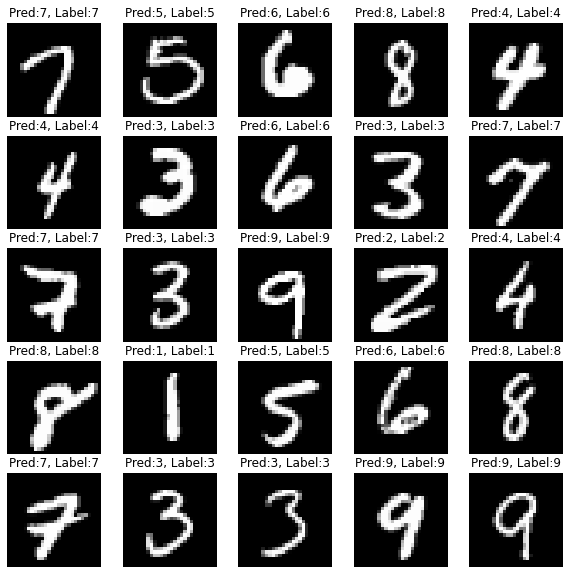

Done


In [ ]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    R.eval() # to evaluation mode 
    y_pred = R.forward(test_x.view(-1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()
print ("Done")